In [1]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as enSentiment
from GerVADER.vaderSentimentGER import SentimentIntensityAnalyzer as gerSentiment
import re
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv ('data/tweets/IchBinHanna.csv')

In [3]:
#prepare data (drop @mentions and URLS, but keep punctuation, as VADER uses it, also keep hashtags) , drop retweets and split it into german and english tweets
#only keep tweets from 01/06/2021 - 30/09/2021
df['new_date'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
df = df.loc[(df['new_date'] > '2021-06-01 00:00:00') & (df['new_date'] <= '2021-09-30 23:59:59')]
df = df.loc[df['reference_type'] != 'retweeted']
df = df[df['text'].str.contains("#ichbinhanna", case = False)]
df['processed'] = df['text'].astype(str)
#remove linebreaks
df['processed'] = df['processed'].replace(r'\\n',  ' ', regex=True)
#remove URLs and mentions (source of regex etc.:https://github.com/mengjie514/Twitter-Sentiment-Analysis-with-Python---Part-IV/blob/master/Project%20Part%204.2%20Sentiment%20Analysis%20with%20Amazon%20datasets.ipynb)
pat1 = r'@[\w_]+'
pat2 = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
pat3 = r'www.[^ ]+'
combined_pat = r'|'.join((pat1, pat2, pat3))
split_pattern = re.compile(r'\b('  + r')\b')
def tweet_cleaner(demo):
    soup = BeautifulSoup(demo, 'lxml') # HTML
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    return stripped
df['processed'] = [tweet_cleaner(t) for t in df['processed']]
df_ger = df.loc[df['lang'] == "de"]
df_en = df.loc[df['lang'] == "en"]

In [4]:
#use VADER (source: https://github.com/cjhutto/vaderSentiment) to analyse the sentiment of english tweets
analyser_en = enSentiment()
df_en['sentiment scores'] = df_en['processed'].apply(analyser_en.polarity_scores)

In [5]:
#use GerVADER(source: https://github.com/KarstenAMF/GerVADER)
analyser_ger = gerSentiment()
df_ger['sentiment scores'] = df_ger['processed'].apply(analyser_ger.polarity_scores)

In [6]:
#split scores into separate columns
df_en = pd.concat([df_en.drop(['sentiment scores'], axis=1), df_en['sentiment scores'].apply(pd.Series)], axis=1)
df_ger = pd.concat([df_ger.drop(['sentiment scores'], axis=1), df_ger['sentiment scores'].apply(pd.Series)], axis=1)
#rejoin data frames
df_sentiment = pd.concat([df_en,df_ger])

In [7]:
#number of tweets left
df_sentiment.shape[0]

19936

In [8]:
#some descriptive statistics
print("Max Sentiment scores:\n neg:{0}\n neu:{1}\n pos:{2}\n compound:{3}".format(df_sentiment['neg'].max(), df_sentiment['neu'].max(), df_sentiment['pos'].max(), df_sentiment['compound'].max()))
print("Mean Sentiment scores:\n neg:{0}\n neu:{1}\n pos:{2}\n compound:{3}".format(round(df_sentiment['neg'].mean(),4), round(df_sentiment['neu'].mean(),4), round(df_sentiment['pos'].mean(),4), round(df_sentiment['compound'].mean(),4)))

Max Sentiment scores:
 neg:0.811
 neu:1.0
 pos:0.863
 compound:0.9937
Mean Sentiment scores:
 neg:0.0508
 neu:0.8345
 pos:0.1147
 compound:0.21


In [9]:
#VADERs documentation suggests that scores below -0.05 imply a negative, between -0.05 and 0.05 a neutral and above a positive sentiment
conditions = [(df_sentiment['compound'] <= -0.05), (df_sentiment['compound'] > -0.05) & (df_sentiment['compound'] < 0.05),(df_sentiment['compound'] >= 0.05)]
values = ['negative', 'neutral', 'positive']
df_sentiment['sentiment'] = np.select(conditions, values)
df_sentiment['sentiment'].value_counts()

positive    11335
negative     4415
neutral      4186
Name: sentiment, dtype: int64

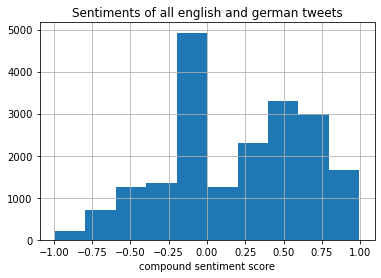

In [10]:
#distribution of overall sentiment scores
df_sentiment['compound'].hist()
plt.title('Sentiments of all english and german tweets')
plt.xlabel('compound sentiment score')
plt.show()

## Development of sentiment over time

In [11]:
#Only store information about day an corresponding sentiment score
df_pos = df_sentiment[['new_date', 'pos']]
df_neg = df_sentiment[['new_date', 'neg']]
df_neu = df_sentiment[['new_date', 'neu']]
df_comp = df_sentiment[['new_date', 'compound']]

In [12]:
#compute mean scores over days
df_pos_day = df_pos.groupby([pd.to_datetime(df_pos['new_date']).dt.date]).mean()
df_pos_day = df_pos_day.reset_index()
df_neg_day = df_neg.groupby([pd.to_datetime(df_neg['new_date']).dt.date]).mean()
df_neg_day = df_neg_day.reset_index()
df_neu_day = df_neu.groupby([pd.to_datetime(df_neu['new_date']).dt.date]).mean()
df_neu_day = df_neu_day.reset_index()
df_comp_day = df_comp.groupby([pd.to_datetime(df_comp['new_date']).dt.date]).mean()
df_comp_day = df_comp_day.reset_index()

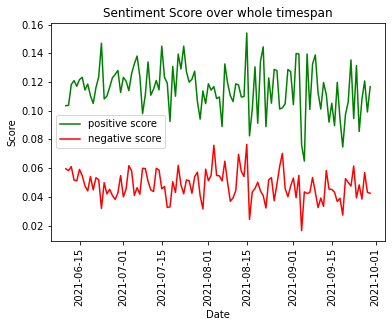

In [13]:
#plot the progress of the positive and negative scores over the whole time span
plt.plot(df_pos_day['new_date'],df_pos_day['pos'], label = 'positive score', color = 'green')
plt.plot(df_neg_day['new_date'],df_neg_day['neg'], label = 'negative score', color = 'red')
#plt.plot(df_neu_day['new_date'],df_neu_day['neu'], label = 'neutral score', color = 'blue')
plt.title('Sentiment Score over whole timespan')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

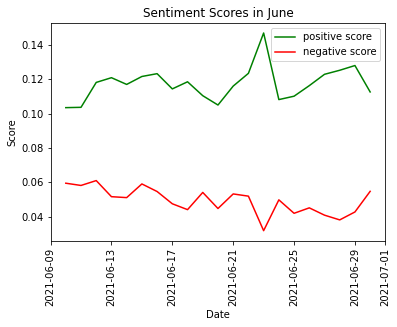

In [14]:
#for a better overview, split the data into months
df_pos_june = df_pos_day.loc[df_pos_day['new_date'] < pd.to_datetime('2021-07-01')]
df_neg_june = df_neg_day.loc[df_neg_day['new_date'] < pd.to_datetime('2021-07-01')]
df_neu_june = df_neu_day.loc[df_neu_day['new_date'] < pd.to_datetime('2021-07-01')]
df_comp_june = df_comp_day.loc[df_comp_day['new_date'] < pd.to_datetime('2021-07-01')]
plt.plot(df_pos_june['new_date'],df_pos_june['pos'], label = 'positive score', color = 'green')
plt.plot(df_neg_june['new_date'],df_neg_june['neg'], label = 'negative score', color = 'red')
#plt.plot(df_neu_day['new_date'],df_neu_day['neu'], label = 'neutral score', color = 'blue')
plt.title('Sentiment Scores in June')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

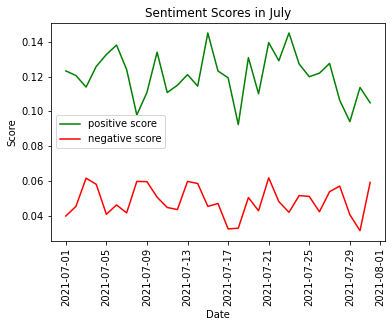

In [15]:
df_pos_july = df_pos_day.loc[(df_pos_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_pos_day['new_date'] < pd.to_datetime('2021-08-01'))]
df_neg_july = df_neg_day.loc[(df_neg_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_neg_day['new_date'] < pd.to_datetime('2021-08-01'))]
df_neu_july = df_neu_day.loc[(df_neu_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_neu_day['new_date'] < pd.to_datetime('2021-08-01'))]
df_comp_july = df_comp_day.loc[(df_comp_day['new_date'] > pd.to_datetime('2021-06-30')) & (df_comp_day['new_date'] < pd.to_datetime('2021-08-01'))]
plt.plot(df_pos_july['new_date'],df_pos_july['pos'], label = 'positive score', color = 'green')
plt.plot(df_neg_july['new_date'],df_neg_july['neg'], label = 'negative score', color = 'red')
#plt.plot(df_neu_day['new_date'],df_neu_day['neu'], label = 'neutral score', color = 'blue')
plt.title('Sentiment Scores in July')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

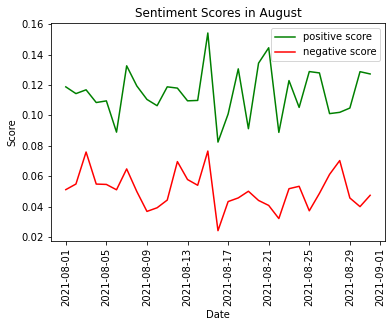

In [16]:
df_pos_august = df_pos_day.loc[(df_pos_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_pos_day['new_date'] < pd.to_datetime('2021-09-01'))]
df_neg_august = df_neg_day.loc[(df_neg_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_neg_day['new_date'] < pd.to_datetime('2021-09-01'))]
df_neu_august = df_neu_day.loc[(df_neu_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_neu_day['new_date'] < pd.to_datetime('2021-09-01'))]
df_comp_august = df_comp_day.loc[(df_comp_day['new_date'] > pd.to_datetime('2021-07-31')) & (df_comp_day['new_date'] < pd.to_datetime('2021-09-01'))]
plt.plot(df_pos_august['new_date'],df_pos_august['pos'], label = 'positive score', color = 'green')
plt.plot(df_neg_august['new_date'],df_neg_august['neg'], label = 'negative score', color = 'red')
#plt.plot(df_neu_day['new_date'],df_neu_day['neu'], label = 'neutral score', color = 'blue')
plt.title('Sentiment Scores in August')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

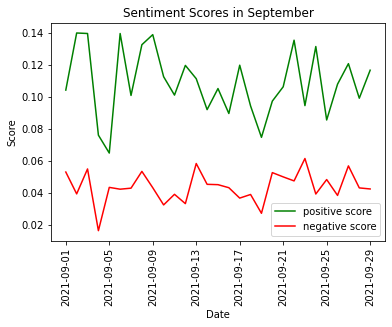

In [17]:
df_pos_september = df_pos_day.loc[(df_pos_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_pos_day['new_date'] < pd.to_datetime('2021-10-01'))]
df_neg_september = df_neg_day.loc[(df_neg_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_neg_day['new_date'] < pd.to_datetime('2021-10-01'))]
df_neu_september = df_neu_day.loc[(df_neu_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_neu_day['new_date'] < pd.to_datetime('2021-10-01'))]
df_comp_september = df_comp_day.loc[(df_comp_day['new_date'] > pd.to_datetime('2021-08-31')) & (df_comp_day['new_date'] < pd.to_datetime('2021-10-01'))]
plt.plot(df_pos_september['new_date'],df_pos_september['pos'], label = 'positive score', color = 'green')
plt.plot(df_neg_september['new_date'],df_neg_september['neg'], label = 'negative score', color = 'red')
#plt.plot(df_neu_day['new_date'],df_neu_day['neu'], label = 'neutral score', color = 'blue')
plt.title('Sentiment Scores in September')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

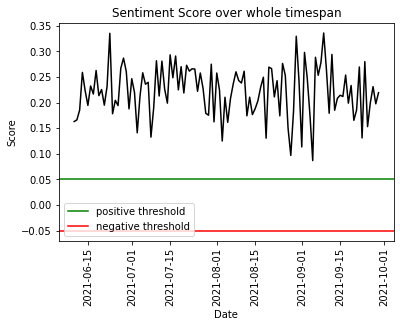

In [18]:
#compound score over time
plt.plot(df_comp_day['new_date'],df_comp_day['compound'], color = 'black')
plt.axhline(y=0.05, color='green', linestyle='-', label = 'positive threshold')
plt.axhline(y=-0.05, color='red', linestyle='-', label = 'negative threshold')
plt.title('Sentiment Score over whole timespan')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

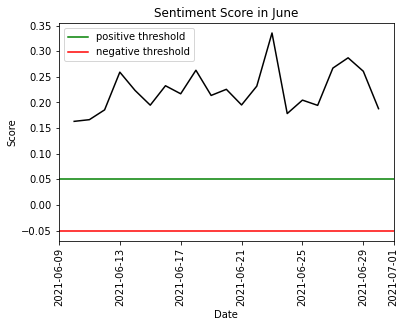

In [19]:
plt.plot(df_comp_june['new_date'],df_comp_june['compound'], color = 'black')
plt.axhline(y=0.05, color='green', linestyle='-', label = 'positive threshold')
plt.axhline(y=-0.05, color='red', linestyle='-', label = 'negative threshold')
plt.title('Sentiment Score in June')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

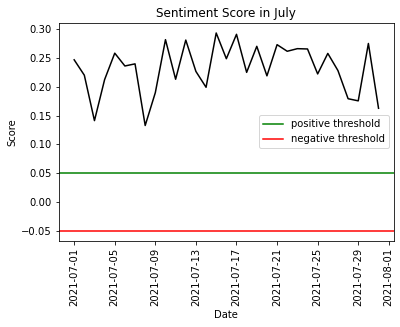

In [20]:
plt.plot(df_comp_july['new_date'],df_comp_july['compound'], color = 'black')
plt.axhline(y=0.05, color='green', linestyle='-', label = 'positive threshold')
plt.axhline(y=-0.05, color='red', linestyle='-', label = 'negative threshold')
plt.title('Sentiment Score in July')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

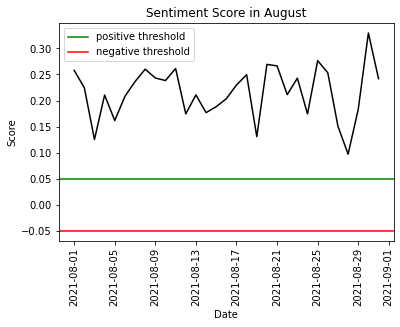

In [21]:
plt.plot(df_comp_august['new_date'],df_comp_august['compound'], color = 'black')
plt.axhline(y=0.05, color='green', linestyle='-', label = 'positive threshold')
plt.axhline(y=-0.05, color='red', linestyle='-', label = 'negative threshold')
plt.title('Sentiment Score in August')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

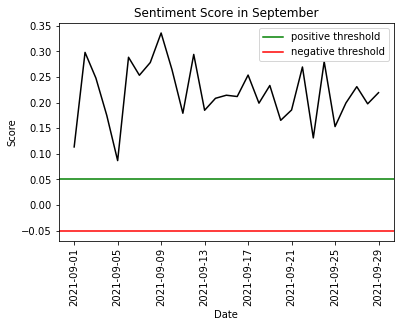

In [22]:
plt.plot(df_comp_september['new_date'],df_comp_september['compound'], color = 'black')
plt.axhline(y=0.05, color='green', linestyle='-', label = 'positive threshold')
plt.axhline(y=-0.05, color='red', linestyle='-', label = 'negative threshold')
plt.title('Sentiment Score in September')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [23]:
df_sentiment_de = df_sentiment.loc[df_sentiment['lang']=='de']
df_sentiment_en = df_sentiment.loc[df_sentiment['lang'] == 'en']
print(df_sentiment_de['sentiment'].value_counts())
print(df_sentiment_de['sentiment'].value_counts(normalize=True))
print(df_sentiment_en['sentiment'].value_counts())
print(df_sentiment_en['sentiment'].value_counts(normalize =True))

positive    10045
negative     3726
neutral      3543
Name: sentiment, dtype: int64
positive    0.580166
negative    0.215202
neutral     0.204632
Name: sentiment, dtype: float64
positive    1290
negative     689
neutral      643
Name: sentiment, dtype: int64
positive    0.491991
negative    0.262777
neutral     0.245233
Name: sentiment, dtype: float64


## Content of positive and negative tweets

### Hashtag co-occurrences to #IchBinHanna in positive and negative tweets

In [24]:
#process hashtag lists
df_sentiment['hashtags'] = df_sentiment['hashtags'].str.replace('[', '').str.replace(']','')
df_sentiment['hashtags separated'] = df_sentiment['hashtags'].str.split(',')
#split into positive, negative and neutral sentiment
df_positive = df_sentiment.loc[df_sentiment['sentiment'] == 'positive']
df_negative = df_sentiment.loc[df_sentiment['sentiment'] == 'negative']
df_neutral = df_sentiment.loc[df_sentiment['sentiment'] == 'neutral']
#flatten the lists to count occurences of all strings and drop all variations of #IchBinHanna
flat_hashtags_pos = df_positive['hashtags separated'].explode().to_frame().dropna()
flat_hashtags_pos = flat_hashtags_pos[-flat_hashtags_pos['hashtags separated'].str.contains("ichbinhanna", case = False)]
flat_hashtags_pos['hashtags separated'] = flat_hashtags_pos['hashtags separated'].apply(lambda x: x.lower())
flat_hashtags_neg = df_negative['hashtags separated'].explode().to_frame().dropna()
flat_hashtags_neg = flat_hashtags_neg[-flat_hashtags_neg['hashtags separated'].str.contains("ichbinhanna", case = False)]
flat_hashtags_neg['hashtags separated'] = flat_hashtags_neg['hashtags separated'].apply(lambda x: x.lower())
flat_hashtags_neu = df_neutral['hashtags separated'].explode().to_frame().dropna()
flat_hashtags_neu = flat_hashtags_neu[-flat_hashtags_neu['hashtags separated'].str.contains("ichbinhanna", case = False)]
flat_hashtags_neu['hashtags separated'] = flat_hashtags_neu['hashtags separated'].apply(lambda x: x.lower())

In [25]:
#count absolute occurences 
positive_count = flat_hashtags_pos.value_counts()
positive_count = positive_count[positive_count >10].reset_index()
negative_count = flat_hashtags_neg.value_counts()
negative_count = negative_count[negative_count > 10].reset_index()
neutral_count = flat_hashtags_neu.value_counts()
neutral_count = neutral_count[neutral_count > 10].reset_index()
#count relative occurences 
positive_rel = flat_hashtags_pos.value_counts(normalize = True)
positive_rel = positive_rel[positive_rel >0.005].reset_index()
negative_rel = flat_hashtags_neg.value_counts(normalize = True)
negative_rel = negative_rel[negative_rel > 0.005].reset_index()
neutral_rel = flat_hashtags_neu.value_counts(normalize = True)
neutral_rel = neutral_rel[neutral_rel > 0.005].reset_index()

In [26]:
print("Most frequent hashtags in positive tweets:\n{}".format(positive_count.head(30)))
print("Most frequent hashtags in negative tweets:\n{}".format(negative_count))
print("Most frequent hashtags in neutral tweets:\n{}".format(neutral_count))

Most frequent hashtags in positive tweets:
                hashtags separated    0
0                     'wisszeitvg'  484
1                     'wisszeitvg'  409
2                   'ichbinreyhan'  360
3               'hannaimbundestag'  292
4                 '95vswisszeitvg'  139
5                  'frististfrust'  116
6                   'wissenschaft'  116
7                   'dauerstellen'  112
8    'acertaindegreeofflexibility'   99
9               'hannaimbundestag'   94
10                  'wissenschaft'   54
11                     'karliczek'   41
12                  'hannastreikt'   41
13                          'bmbf'   40
14                         'btw21'   37
15                     'ugnovelle'   36
16                     'karliczek'   36
17                        'berlhg'   36
18                'hannabeidergew'   34
19             'waspostdocswollen'   33
20                  'dauerstellen'   33
21                        'tvstud'   32
22                  'wirsindhanna'   

In [27]:
print("Most frequent hashtags in positive tweets:\n{}".format(positive_rel))
print("Most frequent hashtags in negative tweets:\n{}".format(negative_rel))
print("Most frequent hashtags in neutral tweets:\n{}".format(neutral_rel))

Most frequent hashtags in positive tweets:
                hashtags separated         0
0                     'wisszeitvg'  0.061026
1                     'wisszeitvg'  0.051570
2                   'ichbinreyhan'  0.045392
3               'hannaimbundestag'  0.036818
4                 '95vswisszeitvg'  0.017526
5                  'frististfrust'  0.014626
6                   'wissenschaft'  0.014626
7                   'dauerstellen'  0.014122
8    'acertaindegreeofflexibility'  0.012483
9               'hannaimbundestag'  0.011852
10                  'wissenschaft'  0.006809
11                     'karliczek'  0.005170
12                  'hannastreikt'  0.005170
13                          'bmbf'  0.005044
Most frequent hashtags in negative tweets:
                hashtags separated         0
0                     'wisszeitvg'  0.068508
1                     'wisszeitvg'  0.058195
2                   'ichbinreyhan'  0.042357
3               'hannaimbundestag'  0.042357
4             

In [28]:
#are there hashtags that only occurr in certain categories?
pos_tags = set(positive_count['hashtags separated'])
neg_tags = set(negative_count['hashtags separated'])
neu_tags = set(neutral_count['hashtags separated'])
print("in pos, but not in neg:\n{}".format(pos_tags.difference(neg_tags)))
print("in neg, but not in pos:\n{}".format(neg_tags.difference(pos_tags)))
print("in neu, but not in pos:\n{}".format(neu_tags.difference(pos_tags)))
print("in neu, but not in neg:\n{}".format(neu_tags.difference(neg_tags)))
print("in neg, but not in neu:\n{}".format(neg_tags.difference(neu_tags)))
print("in pos, but not in neu:\n{}".format(pos_tags.difference(neu_tags)))

in pos, but not in neg:
{"'usa'", " 'promotion'", " 'academicmentalhealth'", " '95wisspausen'", " 'lehre'", " 'corona'", " 'hannainzahlen'", "'woisthanna'", " 'befristung'", "'acertaindegreeofflexibility'", " 'twittercampus'", "'letzte3semester'", "'berlhg'", " 'dauerstellenfürdaueraufgaben'", " 'universität'", " 'spd'", "'anschlussverwendung'", " 'tenuretrack'", " 'gutearbeit'", " 'unionize'", "'tvstud'", " 'ugnovelle'", "'unbezahlt'", "'ichbinreyhan'", " 'braindrain'", " 'wisskomm'", " 'keineausnahme'", "'hannabeidergew'", "'frististfrust'", " 'gruenermist'", " 'hochschule'", " 'arbeiterkind'", " 'waspostdocswollen'", " 'bundestag'", " 'bildung'", "'ugnovelle'", " 'unbezahlt'", "'btw21'", "'wisskomm'", " 'sand'", "'dauerstellen'", " 'hannagehtwählen'", "'ichwarhanna'", " 'anschlussverwendung'", " 'academictwitter'", " 'r2g'", " 'hochschulen'", "'entfristethanna'", " 'hannaorganisiertsich'", "'academia'", "'bundestag'", " 'hannawählt'", " 'entfristethanna'", "'hanna'", " 'thesis_ev'",

### Word occurrences in positive, negative and neutral tweets

In [29]:
#remove stop words + punctuation and all hashtags, as this information was already observed
df_sentiment['tokenized'] = df_sentiment['text'].apply(lambda x: re.sub("#[A-Za-z0-9_]+","", x))
def rem_url(tweet):
     return " ".join(re.sub("([^0-9A-Za-zßäöü \t])|(\w+:\/\/\S+)", " ", tweet).split())
df_sentiment['tokenized'] = df_sentiment['tokenized'].replace(r'\\n',  ' ', regex=True)
df_sentiment['tokenized'] = df_sentiment['tokenized'].apply(rem_url)
df_sentiment['tokenized'] = df_sentiment['tokenized'].astype(str)
#tokenize tweets
tweet_tokenizer = TweetTokenizer()
df_sentiment['tokenized'] = df_sentiment['tokenized'].apply(lambda x: tweet_tokenizer.tokenize(x.lower()))

In [30]:
nltk.download("stopwords")
german_stop = set(stopwords.words('german'))
english_stop = set(stopwords.words('english'))
df_sentiment['tokenized'] = df_sentiment[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (english_stop)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (german_stop)]).split(),axis=1)
#remove additional stopwords encountered (like "innen" which occurs because of gendering in german), as well as the hashtag itself, rt etc.
add_stop_all = ["rt", "ichbinhanna", "hanna", "mehr", "mal", "innen", "amp"]
add_stop_ger = ["mehr", "mal", "innen", "ja", "schon"]
add_stop_en = []
df_sentiment['tokenized'] = df_sentiment[['tokenized','lang']].apply(lambda x: ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_en)]).split() if x['lang'] == 'en' else ' '.join([word for word in x['tokenized'] if word not in (add_stop_all) and word not in  (add_stop_ger)]).split(),axis=1)
#remove all words consisting of only one character (isn'"t", it'"s" etc.)
df_sentiment['tokenized'] = df_sentiment['tokenized'].apply(lambda x: [word for word in x if len(word) > 1])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
#split into positive, negative and neutral class
df_pos_de_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'positive') & (df_sentiment['lang'] == 'de')]
df_pos_en_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'positive') & (df_sentiment['lang'] == 'en')]
df_neg_de_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'negative')& (df_sentiment['lang'] == 'de')]
df_neg_en_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'positive') & (df_sentiment['lang'] == 'en')]
df_neu_de_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'neutral')& (df_sentiment['lang'] == 'de')]
df_neu_en_tokens = df_sentiment[['tokenized', 'sentiment']].loc[(df_sentiment['sentiment'] == 'positive') & (df_sentiment['lang'] == 'en')]
#concatenate lists of tokens to one string to generate word clouds
df_pos_de_tokens['tokenized'] = df_pos_de_tokens['tokenized'].apply(lambda x: ' '.join(x))
df_pos_en_tokens['tokenized'] = df_pos_en_tokens['tokenized'].apply(lambda x: ' '.join(x))
df_neg_de_tokens['tokenized'] = df_neg_de_tokens['tokenized'].apply(lambda x: ' '.join(x))
df_neg_en_tokens['tokenized'] = df_neg_en_tokens['tokenized'].apply(lambda x: ' '.join(x))
df_neu_de_tokens['tokenized'] = df_neu_de_tokens['tokenized'].apply(lambda x: ' '.join(x))
df_neu_en_tokens['tokenized'] = df_neu_en_tokens['tokenized'].apply(lambda x: ' '.join(x))
#concatenate all strings in column to obtain "bag of words"
pos_de_tokens = ' '.join(df_pos_de_tokens['tokenized'])
pos_en_tokens = ' '.join(df_pos_en_tokens['tokenized'])
neg_de_tokens = ' '.join(df_neg_de_tokens['tokenized'])
neg_en_tokens = ' '.join(df_neg_en_tokens['tokenized'])
neu_de_tokens = ' '.join(df_neu_de_tokens['tokenized'])
neu_en_tokens = ' '.join(df_neu_en_tokens['tokenized'])

In [32]:
#additional stopwords
add_stop = ['wissenschaft', 'germany', 'german', 'system', 'uni', 'year', 'gibt', 'immer', 'work', 'research','one', 'phd', 'research', 'wissenschaftler', 'need', 'job', 'years','thank','people', 'time','good','us','many', 'know', 'academics', 'think', 'make', 'researcher'"ichbinhanna", "hanna", "mehr", "innen",  "amreibahr", "bmbf","bund", "mehr", "innen", "schon", "gehen", "jahr","wissenschaft", "wissenschaftler", "kommen","academia", "academic", "year", "machen", "sagen", "sein","geben", "also", "werden", "german", "germany","gut", "haben", "geht", "gibt", "viele", "seit", "wäre"]
STOPWORDS.update(set(add_stop))

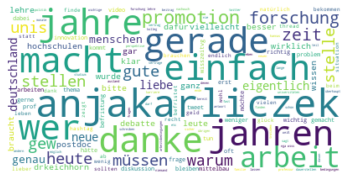

In [33]:
#positive german tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(pos_de_tokens)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

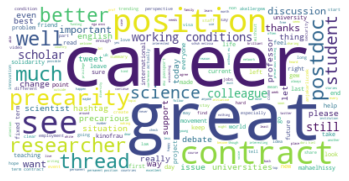

In [34]:
#positive english tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(pos_en_tokens)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

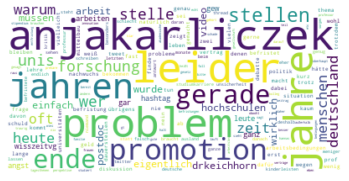

In [35]:
#negative german tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(neg_de_tokens)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

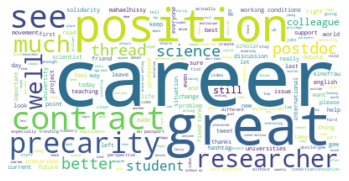

In [36]:
#negative english tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(neg_en_tokens)


plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

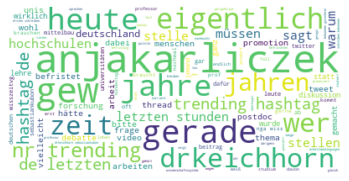

In [37]:
#neutral german tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(neu_de_tokens)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

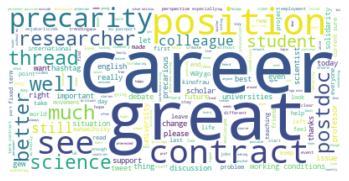

In [38]:
#neutral english tweets wordcloud
wordcloud = WordCloud(background_color="white").generate(neu_en_tokens)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [39]:
#for further investigation
df_out= df_sentiment
compression_opts = dict(method='zip',
                        archive_name='vader_sentiment.csv')  
df_out.to_csv('out.zip', index=True,
          compression=compression_opts) 